# 안개 발생 진단 분류 모델 생성

## 데이터 설명
- 컬럼

    - `Year` : 년도
    - `Month` : 월
    - `Day` : 일
    - `Time` : 시간 (0 ~ 23)
    - `Minute` : 분 (10분 단위)
    - `STN_ID` : 지점 번호
    - `WS10(deg)` : 10분 평균 풍향, 단위: deg
    - `WS10(m/s)` : 10분 평균 풍속, 단위: m/s
    - `TA` : 1분 평균 기온 10분 주기, 단위: C
    - `RE` : 강수 유무 (0:무강수, 1:강수)
    - `HM` : 1분 평균 상대 습도 10분 주기, 단위: %
    - `sun10` : 1분 일사량 10분단위 합계, 단위: MJ
    - `TS` : 1분 평균 지면온도 10분 주기, 단위: C
    - `VIS1` : 1분 평균 시정 10분 주기, 단위: C (VIS1 변수는 시정 구간을 알 수 있는 변수로 검증 데이터에서는 제외)
    - `class` : 시정 구간

- 시정 계급 기준 (비고: 안개의 기준)

    - `1` : 0 < 시정 < 200
    - `2` : 200 <= 시정 < 500
    - `3` : 500 <= 시정 < 1000
    - `4` : 1000 <= 시정


## 데이터 불러오기

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip -q install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 17.9 MB/s eta 0:00:00


In [3]:
!pip -q install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.9 MB/s eta 0:00:00


In [4]:
!pip install imbalanced-learn

In [5]:
# !pip -q install pycaret[full]

In [6]:
# !pip show scikit-learn

In [7]:
# !pip -q install --upgrade scikit-learn

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pickle
import optuna
from optuna.samplers import TPESampler

from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import RandomForestClassifier
# from xgboost import XGBClassifier
# from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import CategoricalNB

from sklearn.model_selection import train_test_split

# from sklearn.preprocessing import TargetEncoder
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer


import warnings
warnings.filterwarnings(action='ignore')

In [9]:
# 데이터셋 경로 지정
# train_path = "../fog_data/fog_train.csv"
# test_path = "../fog_data/fog_test.csv"
train_path = "/content/drive/MyDrive/weather-contest/fog_data/fog_train.csv"
test_path = "/content/drive/MyDrive/weather-contest/fog_data/fog_test.csv"

In [10]:
# 데이터셋 불러오기
fog_train_df = pd.read_csv(train_path, index_col=0).rename(columns=lambda x: x.split('.')[1]).reset_index(drop=True)
fog_test_df = pd.read_csv(test_path, index_col=0).rename(columns=lambda x: x.split('.')[1]).reset_index(drop=True)

In [11]:
fog_train_df.head(3)

,year,month,day,time,minute,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,vis1,class
0,I,1,1,0,10,AA,0.0,0.0,-6.4,0.0,38.9,0.0,-2.8,20000,4
1,I,1,1,0,20,AA,0.0,0.0,-6.3,0.0,37.9,0.0,-2.7,20000,4
2,I,1,1,0,30,AA,0.0,0.0,-6.3,0.0,40.0,0.0,-2.6,20000,4


In [12]:
fog_test_df.head(3)

,year,month,day,time,minute,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,class
0,L,1,1,0,0,AI,329.5,0.6,-2.5,0.0,87.5,0.0,-1.6,NaN
1,L,1,1,0,10,AI,321.8,1.2,-2.5,0.0,88.2,0.0,-1.6,NaN
2,L,1,1,0,20,AI,0.4,0.4,-2.5,0.0,88.6,0.0,-1.7,NaN


In [13]:
# fog_train_df[fog_train_df.eq(-99.9).any(axis=1)]

## Preprocessing

### 컬럼 수정 및 제거

In [14]:
def modify_columns(train_df, test_df):

    # stn_id 수정 : A, B, C, D, E로 수정
    train_df["stn_id"] = train_df["stn_id"].apply(lambda x: x[0])
    test_df["stn_id"] = test_df["stn_id"].apply(lambda x: x[0])

    # year, month, day, time, minute, 컬럼 drop
    train_df.drop(columns=["year", "month", "day", "time", "minute", "vis1"], inplace=True)
    test_df.drop(columns=["year", "month", "day", "time", "minute"], inplace=True)

    return train_df, test_df

In [15]:
train_df, test_df = modify_columns(fog_train_df, fog_test_df)

In [16]:
train_df.head(3)

,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,class
0,A,0.0,0.0,-6.4,0.0,38.9,0.0,-2.8,4
1,A,0.0,0.0,-6.3,0.0,37.9,0.0,-2.7,4
2,A,0.0,0.0,-6.3,0.0,40.0,0.0,-2.6,4


In [17]:
test_df.head(3)

,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,class
0,A,329.5,0.6,-2.5,0.0,87.5,0.0,-1.6,NaN
1,A,321.8,1.2,-2.5,0.0,88.2,0.0,-1.6,NaN
2,A,0.4,0.4,-2.5,0.0,88.6,0.0,-1.7,NaN


### 결측치 확인
- `-99` 데이터
- `-99.9` 데이터

In [18]:
# train, test 데이터셋에서 -99 포함한 컬럼들 동일한지 확인
train_df.columns[train_df.isin([-99]).any()] == test_df.columns[test_df.isin([-99]).any()]

array([ True])

In [19]:
# train, test 데이터셋에서 -99.9 포함한 컬럼들 동일한지 확인
train_df.columns[train_df.isin([-99.9]).any()] == test_df.columns[test_df.isin([-99.9]).any()]

array([ True,  True,  True,  True,  True,  True,  True])

In [20]:
# train, test 데이터셋에서 -99, -99.9 포함한 컬럼 동일하기 때문에 같이 변수로 선언
cols_99 = train_df.columns[train_df.isin([-99]).any()].tolist()
cols_99_9 = train_df.columns[train_df.isin([-99.9]).any()].tolist()

In [21]:
# -99, -99.9 인 값을 컬럼 별로 찾아 np.nan으로 변경
def switch_nan(df, cols):
    for col in cols:
        df.loc[df[col]==-99, col] = np.nan
        df.loc[df[col]==-99.9, col] = np.nan
    return df

In [22]:
# train_df의 컬럼 별로 -99, -99.9 인 값들 찾아서 np.nan으로 치환
train_df = switch_nan(train_df, cols_99)
train_df = switch_nan(train_df, cols_99_9)

# test_df의 컬럼 별로 -99, -99.9 인 값들 찾아서 np.nan으로 치환
test_df = switch_nan(test_df, cols_99)
test_df = switch_nan(test_df, cols_99_9)

In [23]:
train_df.isnull().sum()

stn_id          0
ws10_deg     5910
ws10_ms      5826
ta           3867
re          15228
hm           3616
sun10       43910
ts          88639
class       22516
dtype: int64

In [24]:
test_df.isnull().sum()

stn_id           0
ws10_deg       224
ws10_ms        224
ta              91
re            4503
hm              57
sun10          115
ts            7643
class       262800
dtype: int64

In [25]:
# def check_rate(train_df, test_df):
#     # 결측치 확인

#     # train_df에서 -99인 데이터
#     class_99_tr = train_df[train_df.eq(-99).any(axis=1)].shape[0]
#     # train_df에서 -99.9인 데이터
#     class_99_9_tr = train_df[train_df.eq(-99.9).any(axis=1)].shape[0]

#     total_cnt_tr = train_df.shape[0]
#     class_99_pct_tr = round((class_99_tr/total_cnt_tr)*100, 1)
#     class_99_9_pct_tr = round((class_99_9_tr/total_cnt_tr)*100, 1)

#     # test_df에서 -99인 데이터
#     class_99_test = test_df[test_df.eq(-99).any(axis=1)].shape[0]
#     class_99_9_test = test_df[test_df.eq(-99.9).any(axis=1)].shape[0]

#     total_cnt_test = test_df.shape[0]
#     class_99_pct_test = round((class_99_test/total_cnt_test)*100, 1)
#     class_99_9_pct_test = round((class_99_9_test/total_cnt_tr)*100, 1)

#     df_99 = pd.DataFrame({"train_nan_cnt" : [class_99_tr, class_99_9_tr],
#                           "train_total" :[total_cnt_tr, total_cnt_tr],
#                           "test_nan_cnt" : [class_99_test, class_99_9_test],
#                           "test_total": [total_cnt_test, total_cnt_test],
#                           "train_pct (%)":[class_99_pct_tr, class_99_9_pct_tr],
#                           "test_pct (%)":[class_99_pct_test, class_99_9_pct_test]},
#                           index=["-99", "-99.9"])
#     return df_99

In [26]:
def nan_rate_by_cols(train_df, test_df):
    # 컬럼별 결측치 확인

    # train_df에서 np.nan인 데이터
    nan_tr = train_df.isnull().sum()
    nan_tr_cnt = train_df.isnull().count()

    # test_df에서 np.nan인 데이터
    nan_test = test_df.isnull().sum()
    nan_test_cnt = test_df.isnull().count()

    nan_tr_pct = round((nan_tr/nan_tr_cnt)*100, 1)
    nan_test_pct = round((nan_test/nan_test_cnt)*100, 1)

    missing = pd.concat([nan_tr, nan_tr_pct, nan_test, nan_test_pct],
                        keys=["train_nan", "train_nan_pct", "test_nan", "test_nan_pct"], axis=1)
    return missing

In [27]:
missing = nan_rate_by_cols(train_df, test_df)
missing_sum = pd.DataFrame({"train_nan" : np.sum(missing["train_nan"]),
                            "train_nan_pct" : (np.sum(missing["train_nan"]) / train_df.shape[0])*100,
                            "test_nan" : np.sum(missing["test_nan"])-missing.loc["class", "test_nan"],
                            "test_nan_pct" : ((np.sum(missing["test_nan"])-missing.loc["class", "test_nan"]) / test_df.shape[0]*100)},
                            index=["sum"])
missing_total = pd.concat([missing, missing_sum])

In [28]:
missing

,train_nan,train_nan_pct,test_nan,test_nan_pct
stn_id,0,0.0,0,0.0
ws10_deg,5910,0.2,224,0.1
ws10_ms,5826,0.2,224,0.1
ta,3867,0.1,91,0.0
re,15228,0.5,4503,1.7
hm,3616,0.1,57,0.0
sun10,43910,1.4,115,0.0
ts,88639,2.8,7643,2.9
class,22516,0.7,262800,100.0


In [29]:
# train, test 데이터셋 결측치 데이터프레임 생성
missing_total

,train_nan,train_nan_pct,test_nan,test_nan_pct
stn_id,0,0.000000,0,0.000000
ws10_deg,5910,0.200000,224,0.100000
ws10_ms,5826,0.200000,224,0.100000
ta,3867,0.100000,91,0.000000
re,15228,0.500000,4503,1.700000
hm,3616,0.100000,57,0.000000
sun10,43910,1.400000,115,0.000000
ts,88639,2.800000,7643,2.900000
class,22516,0.700000,262800,100.000000
sum,189512,6.003943,12857,4.892314


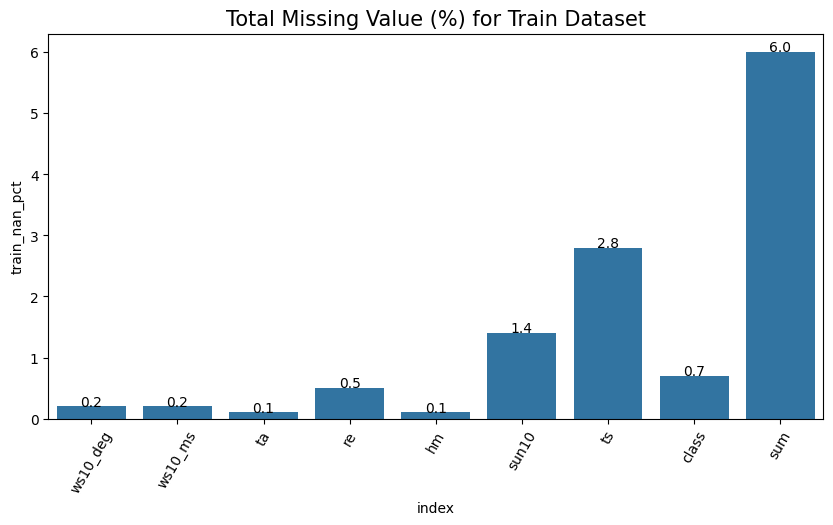

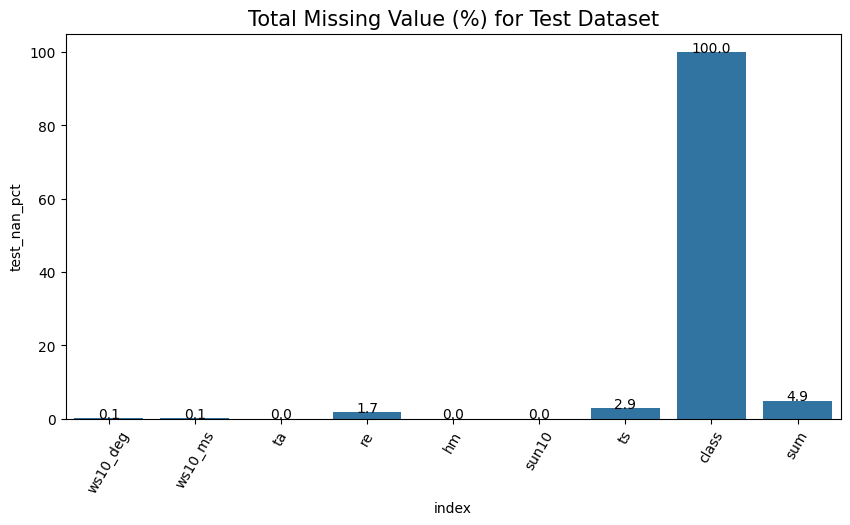

In [30]:
# 결측치 비율 시각화
plt.figure(figsize=(10, 5))
sns_pct = sns.barplot(x="index", y="train_nan_pct", data=missing_total[missing_total["train_nan"]!=0].reset_index())
sns_pct.set_xticklabels(sns_pct.get_xticklabels(), rotation=60)

# bar 그래프 상단에 비율 (%) 표기
for bar in sns_pct.patches:
    height = bar.get_height()                   # .get_height() : y좌표

    plt.text(bar.get_x() + bar.get_width()/2,   # 퍼센트 글자 위치
             height+0.01,                        # 퍼센트 글자 높이
             "%.1f" % height,                   # 퍼센트 소수점 지정
             ha="center")                       # 가운데 정렬

# 시각화 제목 이름, 폰트 크기 지정
sns_pct.set_title("Total Missing Value (%) for Train Dataset", fontsize=15)
# plt.show()

# 결측치 비율 시각화
plt.figure(figsize=(10, 5))
sns_pct = sns.barplot(x="index", y="test_nan_pct", data=missing_total[missing_total["test_nan"]!=0].reset_index())
sns_pct.set_xticklabels(sns_pct.get_xticklabels(), rotation=60)

# bar 그래프 상단에 비율 (%) 표기
for bar in sns_pct.patches:
    height = bar.get_height()                   # .get_height() : y좌표

    plt.text(bar.get_x() + bar.get_width()/2,   # 퍼센트 글자 위치
             height+0.01,                        # 퍼센트 글자 높이
             "%.1f" % height,                   # 퍼센트 소수점 지정
             ha="center")                       # 가운데 정렬

# 시각화 제목 이름, 폰트 크기 지정
sns_pct.set_title("Total Missing Value (%) for Test Dataset", fontsize=15)
plt.show()

#### 결측치 비율에 따른 결측치 처리 방법 선택
- 결측치 비율 `10% 미만` : 제거 또는 대체
- 결측치 비율 `10% 이상 20% 미만` : 모델 기반 처리
- 결측치 비율 `20% 이상` : 모델 기반 처리
- 출처 : https://cheris8.github.io/data%20analysis/DP-NA-Imputation/

### 결측치 제거

In [31]:
# train 데이터셋 결측치 제거
train_df.dropna(inplace=True)

In [32]:
train_df.isnull().sum()

stn_id      0
ws10_deg    0
ws10_ms     0
ta          0
re          0
hm          0
sun10       0
ts          0
class       0
dtype: int64

## 모델링

### 데이터 분리

#### Train, Validation 데이터 분리

In [33]:
# Target 컬럼 : class
target = "class"

# train_df의 컬럼들 중 target (class) 제외한 컬럼들 features에 선언
features = train_df.drop(columns=[target]).columns

In [34]:
# validation 데이터셋 생성
# stratify=train_df[target] : validation 데이터의 분류 target 비율을 train 데이터와 같게 맞춰준다
train, val = train_test_split(train_df, train_size=0.75, random_state=42, stratify=train_df[target])

In [35]:
# train, validation 데이터셋 shape 확인
train.shape, val.shape

((2246137, 9), (748713, 9))

In [36]:
train[target].value_counts(normalize=True)

class
4.0    0.989408
2.0    0.003998
3.0    0.003987
1.0    0.002607
Name: proportion, dtype: float64

In [37]:
val[target].value_counts(normalize=True)

class
4.0    0.989408
2.0    0.003999
3.0    0.003987
1.0    0.002606
Name: proportion, dtype: float64

### 인코딩

#### Label Encoding

In [38]:
# stn_id를 각각 1 ~ 5로 정한 딕셔너리 생성
stn_id_map = {"A" : 1,
              "B" : 2,
              "C" : 3,
              "D" : 4,
              "E" : 5}

In [39]:
# Label Encoding 적용을 위해 train, val, test 데이터 copy()
train_labeled = train.copy()
val_labeled = val.copy()
test_labeled = test_df.copy()

In [40]:
# stn_id_map을 바탕으로 stn_id 컬럼 mapping
train_labeled["stn_id"] = train_labeled["stn_id"].map(stn_id_map)
val_labeled["stn_id"] = val_labeled["stn_id"].map(stn_id_map)
test_labeled["stn_id"] = test_labeled["stn_id"].map(stn_id_map)

In [41]:
train_labeled.head(3)

,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,class
1607733,2,123.1,1.1,27.5,0.0,79.8,0.0,28.3,4.0
2957173,4,18.5,3.2,6.8,0.0,81.2,0.0,5.9,4.0
1260005,1,0.0,1.3,-3.8,0.0,83.3,0.0,-2.0,4.0


In [42]:
val_labeled.head(3)

,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,class
1616787,2,103.6,2.5,20.7,0.0,60.8,0.00,19.8,4.0
3132351,5,287.0,6.2,29.1,0.0,59.8,0.24,37.8,4.0
244330,1,263.4,2.6,29.9,0.0,73.9,0.06,31.6,4.0


In [43]:
test_labeled.head(3)

,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,class
0,1,329.5,0.6,-2.5,0.0,87.5,0.0,-1.6,NaN
1,1,321.8,1.2,-2.5,0.0,88.2,0.0,-1.6,NaN
2,1,0.4,0.4,-2.5,0.0,88.6,0.0,-1.7,NaN


#### X, y 데이터 분리

In [44]:
# train, validation, test 데이터 나눠준다
X_train_labeled = train_labeled[features]
y_train_labeled = train_labeled[target]

# validation 데이터 나눠준다
X_val_labeled = val_labeled[features]
y_val_labeled = val_labeled[target]

# test 데이터 나눠준다 (class 제거)
X_test_labeled = test_labeled[features]

In [45]:
X_train_labeled.shape, y_train_labeled.shape, X_val_labeled.shape, y_val_labeled.shape, X_test_labeled.shape

((2246137, 8), (2246137,), (748713, 8), (748713,), (262800, 8))

### Baseline 모델 생성

In [46]:
# 의사결정나무 모델로 Baseline 모델 생성
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_labeled, y_train_labeled)

DecisionTreeClassifier(random_state=42)

In [47]:
y_val_pred = dt.predict(X_val_labeled)
# accuracy_score(y_val_labeled, y_val_pred)

### CSI 지수 생성

In [48]:
# CSI 지수 함수 생성
def csi_index(y_true, y_pred):

    model_cm = confusion_matrix(y_true, y_pred)

    H = (model_cm[0][0] + model_cm[1][1] + model_cm[2][2])
    F = (model_cm[0][1] + model_cm[0][2] +
            model_cm[1][0] + model_cm[1][2] +
            model_cm[2][0] + model_cm[2][1] +
            model_cm[3][0] + model_cm[3][1] + model_cm[3][2])
    M = (model_cm[0][3] + model_cm[1][3] + model_cm[2][3])

    model_csi = H / (H + F + M)

    return model_csi

csi_scorer = make_scorer(csi_index, greater_is_better=True)

In [49]:
def model_comparison(models, X_train, y_train, X_val, y_val, when="Before"):
    models_results = []

    for model_name, model in models:

        # 모델 생성 및 훈련
        # 트리 기반 모델들은 각 변수의 information gain을 기반으로 판단하기 때문에 굳이 스케일링 해줄 필요가 없다

        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)

        # 모델의 Accuracy, Precision, Recall, F1 score 확인
        accuracy = accuracy_score(y_val, y_val_pred)
        precision = precision_score(y_val, y_val_pred, average="weighted")
        recall = recall_score(y_val, y_val_pred, average="weighted")
        f1_score_ = f1_score(y_val, y_val_pred, average="weighted")
        csi_index_ = csi_index(y_val, y_val_pred)
        # rootMeanSqLogErr = get_rmsle(y_val, y_val_pred)

        # 결과를 리스트에 저장
        models_results.append({"Model" : model_name,
                               "Accuracy" : np.round(accuracy, 4),
                               "Precision" : np.round(precision, 4),
                               "Recall" : np.round(recall, 4),
                               "F1 Score" : np.round(f1_score_, 4),
                               "CSI Index" : np.round(csi_index_, 4)
                               # "Accuracy" : '{:.2f}'.format(accuracy),
                               # "Precision" : '{:.2f}'.format(precision),
                               # "Recall" : '{:.2f}'.format(recall),
                               # "F1 Score" : '{:.2f}'.format(f1_score_),
                               # "R2 Score" : '{:.2f}'.format(model.score(X_val, y_val))
                               })

    # 결과 리스트를 DataFrame으로 변환
    models_df = pd.DataFrame(models_results)

    print(f"\n======== Models {when} Hyper Parameter Tuning ========\n")

    # return models_df.sort_values(by=["RMSLE", "R2 Score"], ascending=[True, False]).reset_index(drop=True)
    return models_df.sort_values(by=["CSI Index", "Accuracy", "F1 Score"],
                                 ascending=[False, True, False]
                                 ).reset_index(drop=True)


In [ ]:
baseline_model = [("Decision Tree", DecisionTreeClassifier(random_state=42))]
model_comparison(baseline_model, X_train_labeled, y_train_labeled, X_val_labeled, y_val_labeled)


====== Models Before Hyper Parameter Tuning ======


,Model,Accuracy,Precision,Recall,F1 Score,CSI Index
0,Decision Tree,0.9859,0.9869,0.9859,0.9864,0.1862


### 하이퍼 파라미터 튜닝 전 모델 생성 (CatBoost, Naive Bayes)

In [ ]:
models = [
    ("Decision Tree", DecisionTreeClassifier(random_state=42)),
    ("CatBoost", CatBoostClassifier(loss_function='MultiClass', verbose=0, task_type="GPU",random_state=42)),
    ("Naive Bayes", GaussianNB())
]

In [ ]:
model_comparison(models, X_train_labeled, y_train_labeled, X_val_labeled, y_val_labeled)


====== Models Before Hyper Parameter Tuning ======


,Model,Accuracy,Precision,Recall,F1 Score,CSI Index
0,Decision Tree,0.9859,0.9869,0.9859,0.9864,0.1862
1,CatBoost,0.9903,0.9867,0.9903,0.9869,0.1186
2,Naive Bayes,0.9425,0.9807,0.9425,0.9606,0.0254


## 하이퍼 파라미터 튜닝

### CatBoost

In [ ]:
# optuna sampling seed 고정
sampler = TPESampler(seed=42)

In [ ]:
# https://practicaldatascience.co.uk/machine-learning/how-to-tune-a-catboostclassifier-model-with-optuna
# https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/002_configurations.html#configurations
# https://catboost.ai/en/docs/concepts/parameter-tuning#methods-for-hyperparameter-search-by-optuna

def objective_cat(trial):
    params = {
        # "loss_function":'MultiClass',
        "iterations": trial.suggest_int("iterations", 100, 1000),
        # "iterations" : trial.suggest_int('n_estimators', 500, 4000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        "depth": trial.suggest_int("depth", 3, 10),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Poisson"]),
        "random_strength": trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "od_type": trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        "od_wait": trial.suggest_int("od_wait", 10, 50),
        # "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        # "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
        # "verbose": False
    }

    model = CatBoostClassifier(**params,
                               loss_function="MultiClass",
                               silent=True,
                               task_type="GPU",
                               random_state=42)

    model.fit(X_train_labeled, y_train_labeled)
    predictions = model.predict(X_val_labeled)
    csi = csi_index(y_val_labeled, predictions)

    return csi

In [ ]:
study_cat = optuna.create_study(study_name="catboost", direction='maximize', pruner="MedianPruner", sampler=sampler)
study_cat.optimize(objective_cat, n_trials=100)

[I 2024-06-06 09:32:59,746] A new study created in memory with name: catboost
[I 2024-06-06 09:33:08,037] Trial 0 finished with value: 0.02546773849327737 and parameters: {'iterations': 207, 'learning_rate': 0.0047340227734041914, 'depth': 10, 'l2_leaf_reg': 1.7061975743910147e-05, 'bootstrap_type': 'Poisson', 'random_strength': 1.8735548907110496e-05, 'bagging_temperature': 0.9717820827209607, 'od_type': 'IncToDec', 'od_wait': 30, 'min_data_in_leaf': 31}. Best is trial 0 with value: 0.02546773849327737.
[I 2024-06-06 09:33:15,661] Trial 1 finished with value: 0.00010068465565847765 and parameters: {'iterations': 356, 'learning_rate': 0.0011851515660043109, 'depth': 7, 'l2_leaf_reg': 0.00106362915273837, 'bootstrap_type': 'Poisson', 'random_strength': 1.49414578394363, 'bagging_temperature': 0.23956189066697242, 'od_type': 'Iter', 'od_wait': 50, 'min_data_in_leaf': 25}. Best is trial 0 with value: 0.02546773849327737.
[I 2024-06-06 09:33:24,851] Trial 2 finished with value: 0.015303562

In [ ]:
print("Best hyperparameters:", study_cat.best_params, sep="\n")
print("-----------------------------------------------------------------------------------------------------------------")
print("Best CSI Index:", study_cat.best_value, sep="\n")

Best hyperparameters:
{'iterations': 904, 'learning_rate': 0.08791641275815368, 'depth': 10, 'l2_leaf_reg': 0.20316887640148765, 'bootstrap_type': 'Poisson', 'random_strength': 0.0013974245504260433, 'bagging_temperature': 0.783946059928889, 'od_type': 'IncToDec', 'od_wait': 34, 'min_data_in_leaf': 65}
-----------------------------------------------------------------------------------------------------------------
Best CSI Index:
0.14768034976924946


In [ ]:
# 하이퍼파라미터별 중요도를 확인할 수 있는 그래프
optuna.visualization.plot_param_importances(study_cat)

In [ ]:
# 하이퍼파라미터 최적화 과정을 확인
optuna.visualization.plot_optimization_history(study_cat)

In [ ]:
cat_optuna = CatBoostClassifier(**study_cat.best_params)

### Naive Bayes

In [ ]:
def objective_gnb(trial):
    params = {
        "var_smoothing" : trial.suggest_float("var_smoothing", 0, 1e-9, log=True)
    }

    model = GaussianNB(**params)

    model.fit(X_train_labeled, y_train_labeled)
    predictions = model.predict(X_val_labeled)
    csi = csi_index(y_val_labeled, predictions)

    return csi

In [ ]:
study_gnb = optuna.create_study(study_name="GaussianNB", direction='maximize', sampler=sampler)
study_gnb.optimize(objective_gnb, n_trials=100)

[I 2024-06-06 10:55:38,985] A new study created in memory with name: GaussianNB
[W 2024-06-06 10:55:38,988] Trial 0 failed with parameters: {} because of the following error: ValueError('The `low` value must be larger than 0 for a log distribution (low=0, high=1e-09).').
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-93-1f0d25c080af>", line 3, in objective_gnb
    "var_smoothing" : trial.suggest_float("var_smoothing", 0, 1e-9, log=True)
  File "/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py", line 162, in suggest_float
    distribution = FloatDistribution(low, high, log=log, step=step)
  File "/usr/local/lib/python3.10/dist-packages/optuna/distributions.py", line 148, in __init__
    raise ValueError(
ValueError: The `low` value must be larger than 0 for a log distribution (low=0, high=1e-09).
[W 2024-06-06 10:55:38,989] Trial 

ValueError: The `low` value must be larger than 0 for a log distribution (low=0, high=1e-09).

## 데이터 불균형 문제

### 언더샘플링

#### RandomUnderSampler

In [74]:
# https://wndofla123.tistory.com/30
# https://datascienceschool.net/03%20machine%20learning/14.02%20%EB%B9%84%EB%8C%80%EC%B9%AD%20%EB%8D%B0%EC%9D%B4%ED%84%B0%20%EB%AC%B8%EC%A0%9C.html#edited-nearest-neighbours

# 불균형 데이터 처리 - 언더 샘플링
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import OneSidedSelection
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.under_sampling import NeighbourhoodCleaningRule

# 불균형 데이터 처리 - 오버 샘플링
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import BorderlineSMOTE

# 데이터 검증
from sklearn.ensemble import RandomForestClassifier #랜덤 포레스트
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_validate

In [51]:
# count_and_plot 그리기 함수
from collections import Counter
from matplotlib import pyplot

def count_and_plot(y):
    counter = Counter(y)
    for k,v in counter.items():
        print('Class=%d, n=%d (%.3f%%)'%(k,v,v / len(y) * 100))
    pyplot.bar(counter.keys(), counter.values())
    pyplot.show()

Class=4, n=2222346 (98.941%)
Class=2, n=8981 (0.400%)
Class=3, n=8955 (0.399%)
Class=1, n=5855 (0.261%)


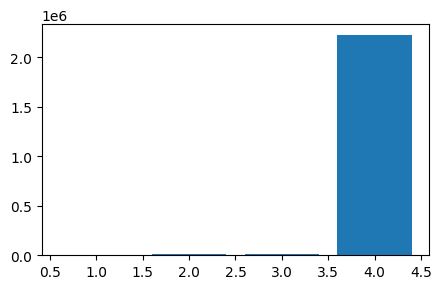

In [52]:
plt.figure(figsize=(5, 3))
count_and_plot(y_train_labeled)

In [ ]:
rus = RandomUnderSampler(sampling_strategy="auto", random_state=42)
X_train_res, y_train_res = rus.fit_resample(X_train_labeled, y_train_labeled)

Class=1, n=5855 (25.000%)
Class=2, n=5855 (25.000%)
Class=3, n=5855 (25.000%)
Class=4, n=5855 (25.000%)


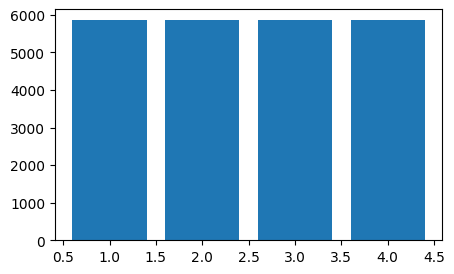

In [ ]:
plt.figure(figsize=(5, 3))
count_and_plot(y_train_res)

In [ ]:
# tl = TomekLinks()
# X_train_tl, y_train_tl = tl.fit_resample(X_train_labeled, y_train_labeled)

In [ ]:
# plt.figure(figsize=(5, 3))
# count_and_plot(y_train_tl)

In [ ]:
# # 전체 데이터셋으로 하이퍼파라미터 튜닝했던 데이터 로드
# pkl_path = "/content/drive/MyDrive/weather-contest/fog_data/cat_model_tek.pkl"
# with open(pkl_path, 'rb') as f:
# 	cat_opt = pickle.load(f)

In [ ]:
# ruv_cat = cat_opt.fit(X_res, y_res)

In [ ]:
# y_pred_ruv = ruv_cat.predict(X_val_labeled)

In [ ]:
# csi_index : 0.03681626651277146
# csi_index(y_val_labeled, y_pred_ruv)

##### RandomUnderSampler 통한 Train dataset으로 다시 모델링 (하이퍼파라미터 튜닝 전)

In [59]:
models = [
    ("Decision Tree", DecisionTreeClassifier(random_state=42)),
    ("CatBoost", CatBoostClassifier(loss_function='MultiClass', verbose=0, task_type="GPU",random_state=42)),
    ("Naive Bayes", GaussianNB())
]

In [ ]:
model_comparison(models, X_train_res, y_train_res, X_val_labeled, y_val_labeled)


======== Models Before Hyper Parameter Tuning ========



,Model,Accuracy,Precision,Recall,F1 Score,CSI Index
0,CatBoost,0.8370,0.9891,0.8370,0.9037,0.0359
1,Decision Tree,0.7529,0.9887,0.7529,0.8516,0.0220
2,Naive Bayes,0.6464,0.9887,0.6464,0.7791,0.0109


#### TomekLinks

In [ ]:
tl = TomekLinks()
X_train_tl, y_train_tl = tl.fit_resample(X_train_labeled, y_train_labeled)

Class=4, n=2214926 (99.262%)
Class=2, n=5378 (0.241%)
Class=3, n=5239 (0.235%)
Class=1, n=5855 (0.262%)


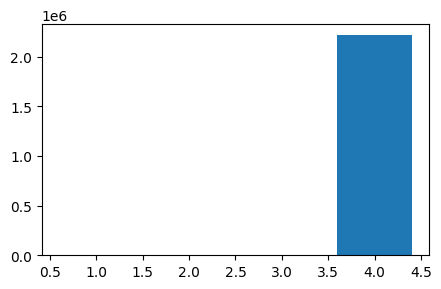

In [ ]:
plt.figure(figsize=(5, 3))
count_and_plot(y_train_tl)

##### TomekLinks 통한 Train dataset으로 다시 모델링 (하이퍼파라미터 튜닝 전)

In [ ]:
model_comparison(models, X_train_tl, y_train_tl, X_val_labeled, y_val_labeled)


======== Models Before Hyper Parameter Tuning ========



,Model,Accuracy,Precision,Recall,F1 Score,CSI Index
0,Decision Tree,0.9870,0.9863,0.9870,0.9866,0.1756
1,CatBoost,0.9903,0.9867,0.9903,0.9868,0.1149
2,Naive Bayes,0.9434,0.9807,0.9434,0.9611,0.0257


#### OSS (OneSidedSelection)

In [ ]:
oss = OneSidedSelection(random_state=42)
X_train_oss, y_train_oss = oss.fit_resample(X_train_labeled, y_train_labeled)

Class=1, n=5855 (0.266%)
Class=2, n=5379 (0.244%)
Class=3, n=5246 (0.238%)
Class=4, n=2183653 (99.251%)


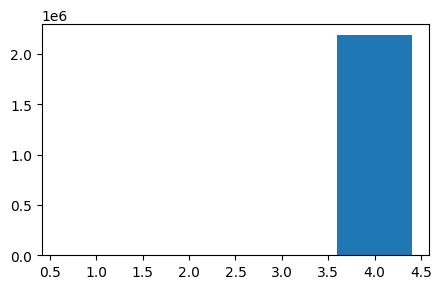

In [ ]:
plt.figure(figsize=(5, 3))
count_and_plot(y_train_oss)

##### OSS 통한 Train dataset으로 다시 모델링 (하이퍼파라미터 튜닝 전)

In [ ]:
model_comparison(models, X_train_oss, y_train_oss, X_val_labeled, y_val_labeled)


======== Models Before Hyper Parameter Tuning ========



,Model,Accuracy,Precision,Recall,F1 Score,CSI Index
0,Decision Tree,0.9868,0.9862,0.9868,0.9864,0.1728
1,CatBoost,0.9903,0.9867,0.9903,0.9868,0.1151
2,Naive Bayes,0.9434,0.9807,0.9434,0.9611,0.0257


ENN (Edited Nearest Neighbours)

In [77]:
enn = EditedNearestNeighbours(kind_sel="all", n_neighbors=5)
X_train_enn, y_train_enn = enn.fit_resample(X_train_labeled, y_train_labeled)

Class=1, n=5855 (0.271%)
Class=2, n=45 (0.002%)
Class=3, n=13 (0.001%)
Class=4, n=2154670 (99.726%)


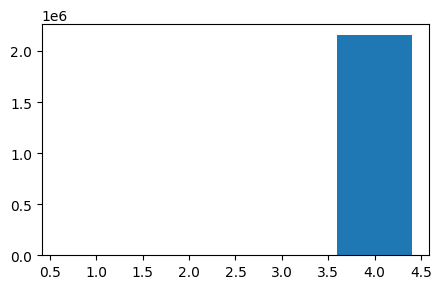

In [78]:
plt.figure(figsize=(5, 3))
count_and_plot(y_train_enn)

In [80]:
model_comparison(models, X_train_enn, y_train_enn, X_val_labeled, y_val_labeled)


======== Models Before Hyper Parameter Tuning ========



,Model,Accuracy,Precision,Recall,F1 Score,CSI Index
0,Decision Tree,0.9876,0.9866,0.9876,0.9850,0.1055
1,CatBoost,0.9894,0.9866,0.9894,0.9857,0.0907
2,Naive Bayes,0.9484,0.9824,0.9484,0.9645,0.0369


Neighbourhood Cleaning Rule

In [81]:
ncr = NeighbourhoodCleaningRule(kind_sel="all", n_neighbors=5)
X_train_ncr, y_train_ncr = ncr.fit_resample(X_train_labeled, y_train_labeled)

In [82]:
model_comparison(models, X_train_ncr, y_train_ncr, X_val_labeled, y_val_labeled)


======== Models Before Hyper Parameter Tuning ========



,Model,Accuracy,Precision,Recall,F1 Score,CSI Index
0,Decision Tree,0.9889,0.9858,0.9889,0.9862,0.1304
1,CatBoost,0.9902,0.9868,0.9902,0.9864,0.0980
2,Naive Bayes,0.9553,0.9812,0.9553,0.9674,0.0303


### 오버샘플링

#### RandomOverSampler

In [56]:
# 랜덤오버샘플링
ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros = ros.fit_resample(X_train_labeled, y_train_labeled)

Class=4, n=2222346 (25.000%)
Class=2, n=2222346 (25.000%)
Class=3, n=2222346 (25.000%)
Class=1, n=2222346 (25.000%)


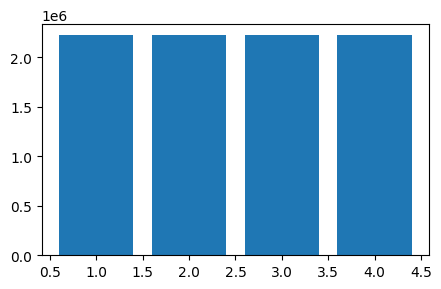

In [57]:
plt.figure(figsize=(5, 3))
count_and_plot(y_train_ros)

In [60]:
model_comparison(models, X_train_ros, y_train_ros, X_val_labeled, y_val_labeled)


======== Models Before Hyper Parameter Tuning ========



,Model,Accuracy,Precision,Recall,F1 Score,CSI Index
0,Decision Tree,0.9861,0.9863,0.9861,0.9862,0.1753
1,CatBoost,0.8949,0.9891,0.8949,0.9371,0.0558
2,Naive Bayes,0.6468,0.9887,0.6468,0.7793,0.0110


#### SMOTE

In [61]:
smote = SMOTE()
X_train_sm, y_train_sm = smote.fit_resample(X_train_labeled, y_train_labeled)

Class=4, n=2222346 (25.000%)
Class=2, n=2222346 (25.000%)
Class=3, n=2222346 (25.000%)
Class=1, n=2222346 (25.000%)


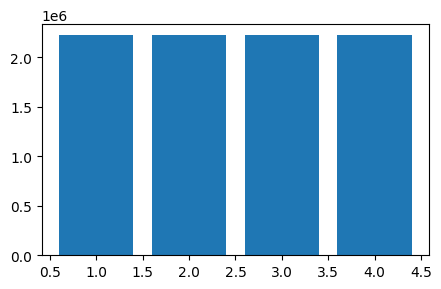

In [65]:
plt.figure(figsize=(5, 3))
count_and_plot(y_train_sm)

In [63]:
model_comparison(models, X_train_sm, y_train_sm, X_val_labeled, y_val_labeled)


======== Models Before Hyper Parameter Tuning ========



,Model,Accuracy,Precision,Recall,F1 Score,CSI Index
0,Decision Tree,0.9713,0.9859,0.9713,0.9781,0.1065
1,CatBoost,0.9652,0.9858,0.9652,0.9747,0.0961
2,Naive Bayes,0.6419,0.9886,0.6419,0.7757,0.0108


#### Borderline SMOTE

In [64]:
bor_sm = BorderlineSMOTE(random_state=42)
X_train_bsm, y_train_bsm = bor_sm.fit_resample(X_train_labeled, y_train_labeled)

Class=4, n=2222346 (25.000%)
Class=2, n=2222346 (25.000%)
Class=3, n=2222346 (25.000%)
Class=1, n=2222346 (25.000%)


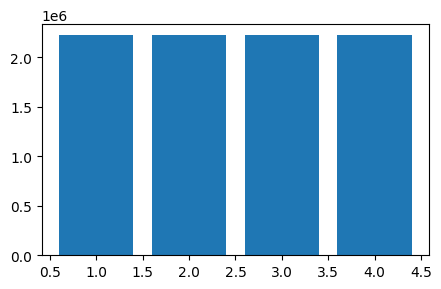

In [66]:
plt.figure(figsize=(5, 3))
count_and_plot(y_train_bsm)

In [67]:
model_comparison(models, X_train_bsm, y_train_bsm, X_val_labeled, y_val_labeled)


======== Models Before Hyper Parameter Tuning ========



,Model,Accuracy,Precision,Recall,F1 Score,CSI Index
0,Decision Tree,0.9799,0.9860,0.9799,0.9828,0.1380
1,CatBoost,0.9706,0.9858,0.9706,0.9776,0.1065
2,Naive Bayes,0.6836,0.9887,0.6836,0.8058,0.0124


#### ADASYN

In [68]:
ada = ADASYN(random_state=42)
X_train_ada, y_train_ada = ada.fit_resample(X_train_labeled, y_train_labeled)

Class=4, n=2222346 (24.992%)
Class=2, n=2222476 (24.994%)
Class=3, n=2223996 (25.011%)
Class=1, n=2223358 (25.004%)


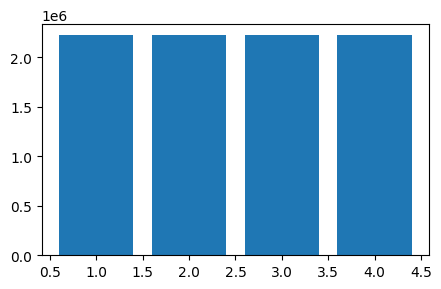

In [69]:
plt.figure(figsize=(5, 3))
count_and_plot(y_train_ada)

In [70]:
model_comparison(models, X_train_ada, y_train_ada, X_val_labeled, y_val_labeled)


======== Models Before Hyper Parameter Tuning ========



,Model,Accuracy,Precision,Recall,F1 Score,CSI Index
0,Decision Tree,0.9711,0.9860,0.9711,0.9780,0.1076
1,CatBoost,0.9636,0.9859,0.9636,0.9738,0.0924
2,Naive Bayes,0.6362,0.9886,0.6362,0.7715,0.0105


## 하이퍼 파라미터 튜닝

### 언더샘플링한 데이터로 진행 (RandomUnderSampler)

#### CatBoost

In [ ]:
# optuna sampling seed 고정
sampler = TPESampler(seed=42)

In [ ]:
# 전체 데이터셋으로 서치했던 하이퍼파라미터 범위 참고
# -> 범위를 참고하여 좁혀서 다시 Optuna를 통해 하이퍼파라미터 튜닝 시도

# {'iterations': 904,
#  'learning_rate': 0.08791641275815368,
#  'depth': 10,
#  'l2_leaf_reg': 0.20316887640148765,
#  'bootstrap_type': 'Poisson',
#  'random_strength': 0.0013974245504260433,
#  'bagging_temperature': 0.783946059928889,
#  'od_type': 'IncToDec',
#  'od_wait': 34,
#  'min_data_in_leaf': 65}

In [ ]:
# https://practicaldatascience.co.uk/machine-learning/how-to-tune-a-catboostclassifier-model-with-optuna
# https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/002_configurations.html#configurations
# https://catboost.ai/en/docs/concepts/parameter-tuning#methods-for-hyperparameter-search-by-optuna

def objective_res_cat(trial):
    params = {
        # "loss_function":'MultiClass',
        "iterations": trial.suggest_int("iterations", 700, 1000),
        # "iterations" : trial.suggest_int('n_estimators', 500, 4000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1e-2, log=True),
        "depth": trial.suggest_int("depth", 3, 10),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-1, 1.0, log=True),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Poisson"]),
        "random_strength": trial.suggest_float("random_strength", 1e-3, 1e-1, log=True),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.5, 1.0),
        "od_type": trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        "od_wait": trial.suggest_int("od_wait", 30, 50),
        # "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        # "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 50, 100),
        # "verbose": False
    }

    model = CatBoostClassifier(**params,
                               loss_function="MultiClass",
                               silent=True,
                               task_type="GPU",
                               random_state=42)

    model.fit(X_train_res, y_train_res)
    predictions = model.predict(X_val_labeled)
    csi = csi_index(y_val_labeled, predictions)

    return csi

In [ ]:
study_res_cat = optuna.create_study(study_name="catboost_res",
                                    direction='maximize',
                                    pruner="MedianPruner",
                                    sampler=sampler)

study_res_cat.optimize(objective_res_cat, n_trials=100)

[I 2024-06-09 09:42:31,194] A new study created in memory with name: catboost_res
[I 2024-06-09 09:42:40,065] Trial 0 finished with value: 0.031961789982903624 and parameters: {'iterations': 812, 'learning_rate': 0.00892718030435363, 'depth': 8, 'l2_leaf_reg': 0.3968793330444371, 'bootstrap_type': 'Bayesian', 'random_strength': 0.0013066739238053278, 'bagging_temperature': 0.9330880728874675, 'od_type': 'Iter', 'od_wait': 30, 'min_data_in_leaf': 99}. Best is trial 0 with value: 0.031961789982903624.
[I 2024-06-09 09:42:43,944] Trial 1 finished with value: 0.024714263458297334 and parameters: {'iterations': 950, 'learning_rate': 0.0016305687346221474, 'depth': 4, 'l2_leaf_reg': 0.1525472945805261, 'bootstrap_type': 'Poisson', 'random_strength': 0.007309539835912915, 'bagging_temperature': 0.645614570099021, 'od_type': 'IncToDec', 'od_wait': 36, 'min_data_in_leaf': 68}. Best is trial 0 with value: 0.031961789982903624.
[I 2024-06-09 09:42:47,291] Trial 2 finished with value: 0.0265732637

In [ ]:
print("Best hyperparameters:", study_res_cat.best_params, sep="\n")
print("-----------------------------------------------------------------------------------------------------------------")
print("Best CSI Index:", study_res_cat.best_value, sep="\n")

Best hyperparameters:
{'iterations': 923, 'learning_rate': 0.00979258152234309, 'depth': 10, 'l2_leaf_reg': 0.2353487947977851, 'bootstrap_type': 'Bayesian', 'random_strength': 0.006712500647052562, 'bagging_temperature': 0.567278569703178, 'od_type': 'IncToDec', 'od_wait': 38, 'min_data_in_leaf': 59}
-----------------------------------------------------------------------------------------------------------------
Best CSI Index:
0.03457977711761839


In [ ]:
# 하이퍼파라미터별 중요도를 확인할 수 있는 그래프
optuna.visualization.plot_param_importances(study_res_cat)

In [ ]:
# 하이퍼파라미터 최적화 과정을 확인
optuna.visualization.plot_optimization_history(study_res_cat)

In [ ]:
cat_res_optuna = CatBoostClassifier(**study_res_cat.best_params)

In [ ]:
# 언더샘플링 후 하이퍼파라미터 튜닝 거친 모델 pickle 저장
with open(file='/content/drive/MyDrive/weather-contest/fog_data/cat_res_model_tek.pkl', mode='wb') as f:
    pickle.dump(study_res_cat, f)